**Import Required Libraries**

In [20]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

**Creating a Balanced Subset of the Dataset**

In [3]:
def create_balanced_subset(source_dir, target_dir, num_classes=10, num_images_per_class=100):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    all_classes = os.listdir(source_dir)
    selected_classes = all_classes[:num_classes] if len(all_classes) > num_classes else all_classes
    
    for class_name in selected_classes:
        class_dir = os.path.join(source_dir, class_name)
        target_class_dir = os.path.join(target_dir, class_name)
        os.makedirs(target_class_dir, exist_ok=True)
        
        all_images = os.listdir(class_dir)
        sampled_images = random.sample(all_images, min(num_images_per_class, len(all_images)))
        
        for img in sampled_images:
            src_img_path = os.path.join(class_dir, img)
            dst_img_path = os.path.join(target_class_dir, img)
            shutil.copy(src_img_path, dst_img_path)

source_dir = 'food_dataset/images/'
target_dir = 'food-101/subset/'
create_balanced_subset(source_dir, target_dir)


**Data Augmentation and Preprocessing**

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

train_generator = datagen.flow_from_directory(
    target_dir,
    subset='training',
    target_size=(100, 100),  # Medium size
    batch_size=16,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    target_dir,
    subset='validation',
    target_size=(100, 100),  # Medium size
    batch_size=16,
    class_mode='categorical'
)


Found 2199 images belonging to 10 classes.
Found 544 images belonging to 10 classes.


**Building ResNet50 Model**

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


**Defining Learning Rate Scheduler**

In [6]:
# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[lr_scheduler]
)


Epoch 1/20


C:\Users\Nisha\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 127s 758ms/step - accuracy: 0.3296 - loss: 1.9703 - val_accuracy: 0.0993 - val_loss: 16.0552 - learning_rate: 1.0000e-04
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 106s 766ms/step - accuracy: 0.6214 - loss: 1.1423 - val_accuracy: 0.0993 - val_loss: 8.3729 - learning_rate: 1.0000e-04
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 106s 767ms/step - accuracy: 0.7246 - loss: 0.8046 - val_accuracy: 0.1048 - val_loss: 5.4988 - learning_rate: 1.0000e-04
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 106s 765ms/step - accuracy: 0.7604 - loss: 0.6710 - val_accuracy: 0.1140 - val_loss: 3.7294 - learning_rate: 1.0000e-04
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 107s 773ms/step - accuracy: 0.8337 - loss: 0.5172 - val_accuracy: 0.1654 - val_loss: 3.2601 - learning_rate: 1.0000e-04
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 108s 775ms/step - accuracy: 0.8322 - loss: 0.5189 - val_accuracy: 0.3143 - val_loss: 2.8527 - learning_rate: 1.0000e-04
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 105s 757ms

**Evaluating the Model**

In [11]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')


34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.6765 - loss: 1.3532
Validation Accuracy: 68.38%


**Loading and Visualizing Sample Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


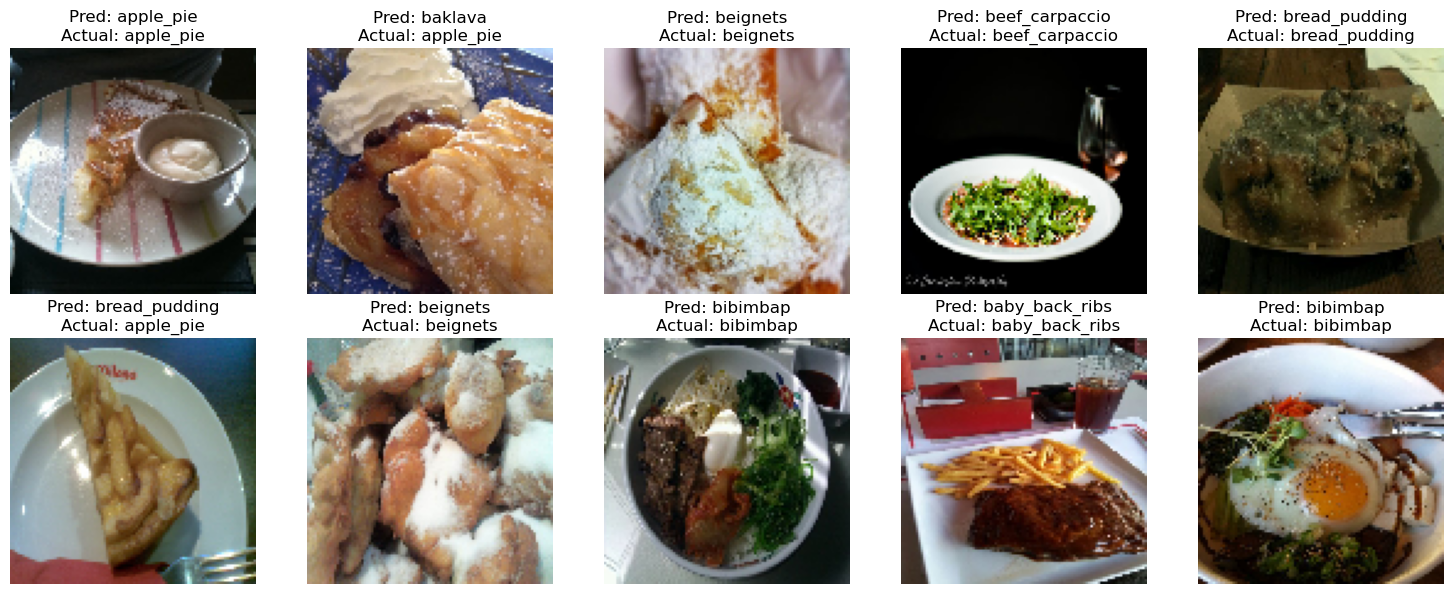

In [24]:
def load_and_prep_image(img_path):
    img = image.load_img(img_path, target_size=(100, 100))  # Adjusted to 100x100
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array

sample_images = random.sample(validation_generator.filepaths, 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, img_path in enumerate(sample_images):
    img_array = load_and_prep_image(img_path)
    pred = model.predict(img_array)
    class_idx = np.argmax(pred, axis=1)[0]
    predicted_class = list(train_generator.class_indices.keys())[class_idx]
    actual_class = os.path.basename(os.path.dirname(img_path))
    

    # Plot the image
    ax = axes[i // 5, i % 5]
    ax.imshow(image.load_img(img_path, target_size=(100, 100)))
    ax.set_title(f'Pred: {predicted_class}\nActual: {actual_class}')
    ax.axis('off')

plt.tight_layout()
plt.show()

**Plotting Training History**

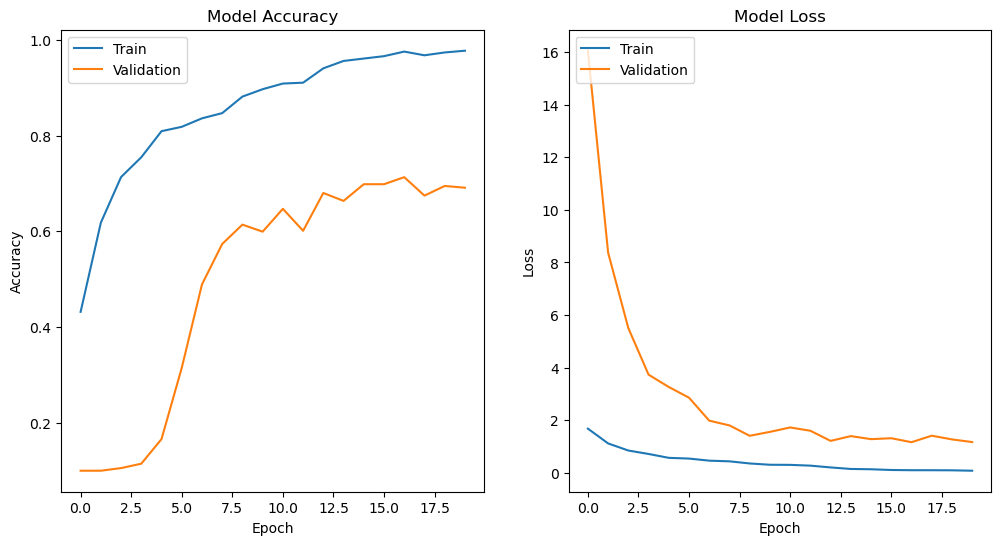

In [19]:
#Plot Training History
if 'history' in globals():
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
else:
    print("No training history found. Please check the training code.")